In [ ]:
# References:
# https://github.com/milesial/Pytorch-UNet/tree/67bf11b4db4c5f2891bd7e8e7f58bcde8ee2d2db

In [ ]:
# !pip install torch torchvision

### UNET Generation (One Image)

In [1]:
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

In [2]:
# PARAMETERS
img_size = 256
noise = torch.randn(1, 3, img_size, img_size)
image_url = "https://raw.githubusercontent.com/yungewww/AIGC-LLM-ToolBox/refs/heads/main/dataset/cat.jpg"

torch.Size([1, 3, 256, 256])


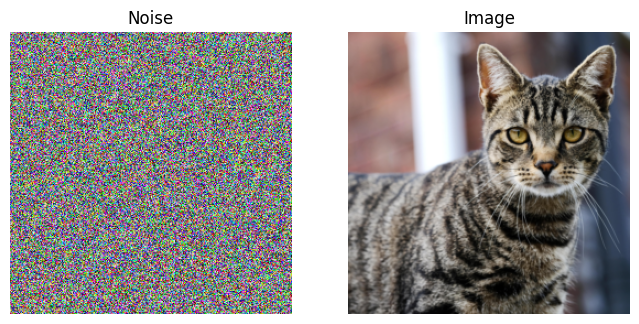

In [3]:
# PREPROCESS IMAGE

def preprocess_image(url, img_size, type = 'image'):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    tensor = transform(img).unsqueeze(0)

    return tensor

def show_tensor_images(tensors, names=None):
    num_imgs = len(tensors)
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs * 4, 4))

    if num_imgs == 1:
        axs = [axs]

    for i, tensor in enumerate(tensors):
        img = transforms.ToPILImage()(tensor.squeeze(0))
        axs[i].imshow(img)
        if names is not None and len(names) > i:
            axs[i].set_title(names[i])
        else:
            axs[i].set_title(f'Image {i+1}')
        axs[i].axis('off')  # 关闭坐标轴

    plt.show()

# tensor shape should be (1, C, H, W)
image_tensor = preprocess_image(image_url, img_size)
print(image_tensor.shape)

show_tensor_images([noise, image_tensor], ['Noise', 'Image'])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class UNetForImageGeneration(nn.Module):
    def __init__(self, out_channels=3):
        super(UNetForImageGeneration, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Contracting path
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = CBR(512, 1024)

        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        # 生成 RGB 图像，因此输出 3 个通道
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))

        # Decoding
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # 使用 tanh 来将输出的像素值限制在 [-1, 1] 之间
        return torch.tanh(self.final(dec1))

# 实例化模型，生成 RGB 图像
model = UNetForImageGeneration(out_channels=3).to('cuda')

torch.Size([1, 3, 256, 256])


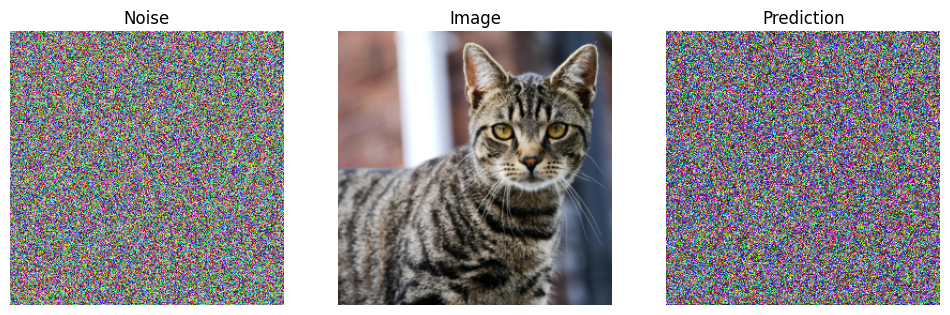

In [5]:
# IF NOT TRAINED
pred = model(noise.to('cuda'))
print(pred.shape)
show_tensor_images([noise, image_tensor, pred], ['Noise', 'Image', 'Prediction'])

Epoch [1/50], Loss: 0.2714330554008484
Epoch [2/50], Loss: 0.22843307256698608
Epoch [3/50], Loss: 0.17051148414611816
Epoch [4/50], Loss: 0.13501903414726257
Epoch [5/50], Loss: 0.12249653786420822
Epoch [6/50], Loss: 0.09868742525577545
Epoch [7/50], Loss: 0.0804535374045372
Epoch [8/50], Loss: 0.0648898035287857
Epoch [9/50], Loss: 0.05440543219447136
Epoch [10/50], Loss: 0.04400522634387016


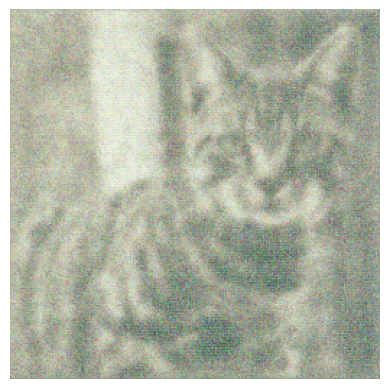

Epoch [11/50], Loss: 0.03588370233774185
Epoch [12/50], Loss: 0.029519494622945786
Epoch [13/50], Loss: 0.024391815066337585
Epoch [14/50], Loss: 0.02082136645913124
Epoch [15/50], Loss: 0.017534025013446808
Epoch [16/50], Loss: 0.01479146908968687
Epoch [17/50], Loss: 0.012886459939181805
Epoch [18/50], Loss: 0.011290354654192924
Epoch [19/50], Loss: 0.010315783321857452
Epoch [20/50], Loss: 0.00939041469246149


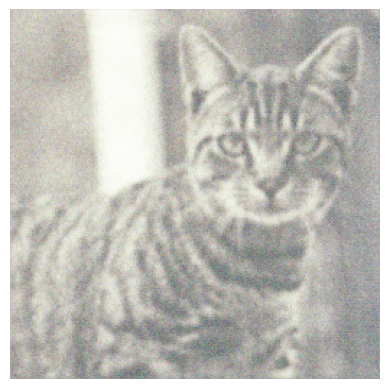

Epoch [21/50], Loss: 0.008836478926241398
Epoch [22/50], Loss: 0.008194230496883392
Epoch [23/50], Loss: 0.007646018173545599
Epoch [24/50], Loss: 0.0071074627339839935
Epoch [25/50], Loss: 0.0066648549400269985
Epoch [26/50], Loss: 0.006244841031730175
Epoch [27/50], Loss: 0.005886423401534557
Epoch [28/50], Loss: 0.0055594551376998425
Epoch [29/50], Loss: 0.005266091786324978
Epoch [30/50], Loss: 0.004997373558580875


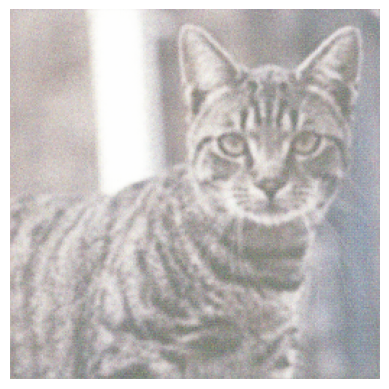

Epoch [31/50], Loss: 0.004700572695583105
Epoch [32/50], Loss: 0.004449975676834583
Epoch [33/50], Loss: 0.004214586690068245
Epoch [34/50], Loss: 0.004000504035502672
Epoch [35/50], Loss: 0.0037933210842311382
Epoch [36/50], Loss: 0.003616373986005783
Epoch [37/50], Loss: 0.003455657046288252
Epoch [38/50], Loss: 0.003328298684209585
Epoch [39/50], Loss: 0.0033301934599876404
Epoch [40/50], Loss: 0.003374692751094699


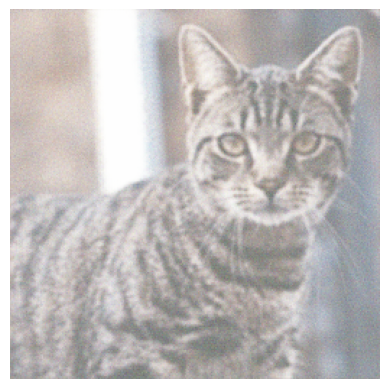

Epoch [41/50], Loss: 0.0031001425813883543
Epoch [42/50], Loss: 0.0028989173006266356
Epoch [43/50], Loss: 0.0028174188919365406
Epoch [44/50], Loss: 0.002702041296288371
Epoch [45/50], Loss: 0.0025828531943261623
Epoch [46/50], Loss: 0.002479660790413618
Epoch [47/50], Loss: 0.0023745836224406958
Epoch [48/50], Loss: 0.002283947542309761
Epoch [49/50], Loss: 0.00219681765884161
Epoch [50/50], Loss: 0.002128718886524439


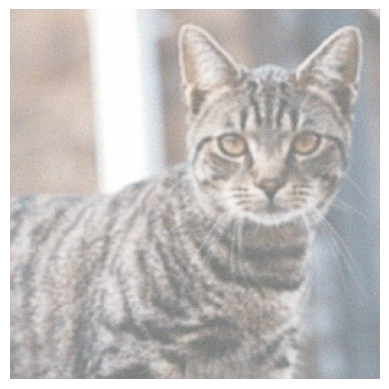

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

noise = noise.to('cuda')
image_tensor = image_tensor.to('cuda')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model_single_image(model, image, label, criterion, optimizer, num_epochs=10, save_interval=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        # Forward
        outputs = model(image)
        loss = criterion(outputs, label)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")

        # 定期保存和显示生成的图像（例如每5个epoch）
        if (epoch + 1) % save_interval == 0:
            save_generated_image(outputs, epoch + 1)

def save_generated_image(tensor, epoch):
    # 将生成的张量从 [-1, 1] 转换为 [0, 1] 以便显示
    img = tensor.detach().cpu().squeeze(0)  # 移除批次维度
    img = (img + 1) / 2  # 假设输出经过 tanh, 需要将其从 [-1, 1] 还原到 [0, 1]

    # 保存生成的图片
    plt.imshow(img.permute(1, 2, 0))  # 将形状从 [C, H, W] 转换为 [H, W, C] 以便显示
    plt.axis('off')
    plt.savefig(f"generated_image_epoch_{epoch}.png")
    plt.show()

# 开始训练，假设噪声为输入，image_tensor 为目标
train_model_single_image(model, noise, image_tensor, criterion, optimizer, num_epochs=50, save_interval=10)


torch.Size([1, 3, 256, 256])


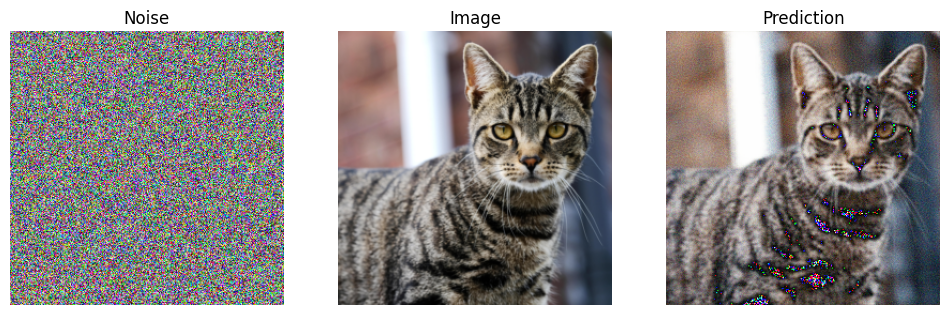

In [7]:
# PREDICTION
pred = model(noise.to('cuda'))
print(pred.shape)
show_tensor_images([noise, image_tensor, pred], ['Noise', 'Image', 'Prediction'])